# Parallel DBSCAN implementation
Based on Huang, Fang, Qiang Zhu, Ji Zhou, Jian Tao, Xiaocheng Zhou, Du Jin, Xicheng Tan, and Lizhe Wang. "Research on the parallelization of the DBSCAN clustering algorithm for spatial data mining based on the spark platform." Remote Sensing 9, no. 12 (2017): 1301.

## Implementation ditails
1. We use spark broadcast variables and accumulators in order to improve performance
1. The implementation is based on kd-tree in order to reduce complexity from O(n^2) to O(nlogn)

## Definitions
* __Core points:__ a point _p_ is a _core_ point if it has neighbors within a given radius _(eps)_ and the number of neighbors is at least _minpts_.
* __Directly density-reachable:__ a point _y_ is directly _density-reachable_ from _x_ if _y_ is within _eps-neighborhood_ of _x_ and _x_ is a _core point_.
* __Density-reachable:__ a point _y_ is _density-reachable_ from x if there is a chain of points _p1, p2, ..., pn=y_ such that p1 is directly density-reachable and _p2, ..., pn_ are directly density-reachable to each previous point in the chain.

## Algorithm outline
1. Split the data to partitions using kd tree.
    1. Attemt to split the data into nearly equal size sets by splitting  the data along the axis with the greatest variance.
    1. The boxes are stored in bounding boxes
    1. Grow each box by twice eps
    1. Assign each point to to all the boxes it is included in
1. Apply the traditional DBSCAN on each box and assign each point to a cluster within the boxes
1. If the same point has been lableled as part of a cluster in two different boxes, it means that those two clusters are actually one single cluster and they should be merged

In [1]:
import math

from numpy import array
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans

import geometry

conf = SparkConf().set("spark.python.profile", "true")
sc = SparkContext(conf=conf)
sc.setLogLevel('ERROR')
# conf = SparkConf().set("spark.driver.memory", "29G")

# For reproducability of results
RANDOM_SEED = 30

%matplotlib inline

sc.getConf().getAll()

21/10/09 17:33:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[('spark.app.id', 'local-1633800808856'),
 ('spark.driver.port', '33515'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.app.startTime', '1633800807764'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.python.profile', 'true'),
 ('spark.executor.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.driver.host', '47abbc84d7cb'),
 ('spark.ui.showConsoleProgress', 'true')]

In [2]:
def parse_line(line):
    return array(tuple(map(float, line.strip().split()[:2])))

data = sc.textFile("../data_samples/dbscan.txt")
parsed_data = data.map(lambda line: parse_line(line))
parsed_data.cache()
parsed_data.take(5)

[array([15.55, 28.65]),
 array([14.9 , 27.55]),
 array([14.45, 28.35]),
 array([14.15, 28.8 ]),
 array([13.75, 28.05])]

In [3]:
def calc_point_centroid_pairs(data, centroids) -> pyspark.rdd.RDD:
    return data.map(lambda point: (tuple(closest_centroid_point(point, centroids)), point))

def sum_of_squares_(centroid_points):
    s = 0
    points_ct = 0
    
    dim = len(centroid_points[0])    # get dimention of the point
    
    for centroid, points in centroid_points:
        centroid_arr = array(centroid)
        for point in points:
            s += euclidean_dist(point, centroid_arr)
            points_ct += 1    # count actual number of points in all the clusters
        points_ct -= 1        # required by the formula, reduce count by one
        
    return math.sqrt(s / (dim * points_ct))

def sum_of_squares_rmsstd(centroid_points):
    s = 0
    points_ct = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
        points_ct += 1
    
    return s, points_ct - 1  

def sum_of_squares_rs(centroid_points):
    s = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
    
    return s

def rmsstd(data: pyspark.rdd.RDD, centroids):
    dim = len(data.first())
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    s, n = point_centroid_pairs.groupByKey().map(sum_of_squares_rmsstd).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return math.sqrt(s / (dim * n))

def rs(data: pyspark.rdd.RDD, centroids):
    g = data.mean()    # calc center of data
    sum_of_squares_total = data.map(lambda point: euclidean_dist(point, g)).sum()
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    sum_of_squres_clusters = point_centroid_pairs.groupByKey().map(sum_of_squares_rs).sum()
    
    return (sum_of_squares_total - sum_of_squres_clusters) / sum_of_squares_total
    

In [4]:
def euclidean_dist(v1, v2):
    return math.sqrt(sum(map(lambda x_y: (x_y[0] - x_y[1])**2,  zip(v1, v2))))

def closest_centroid_point(row, centroids):
    if isinstance(centroids, pyspark.broadcast.Broadcast):
        centroids = centroids.value
    distances = map(lambda centroid: (centroid, euclidean_dist(centroid, row)), centroids)
    return min(distances, key=lambda x: x[1])[0]
    
def closest_centroids(data, centroids):
    return data.map(lambda row: (*row, closest_centroid_point(row, centroids)))

In [5]:
clusters = KMeans.train(parsed_data, 7, maxIterations=150, initializationMode="random")

In [6]:
final_centroids = clusters.centers

In [7]:
def kmeans_color_hash(point):
    hsh = int(point[0] + point[1])
    return hsh

In [8]:
point_centroid = closest_centroids(parsed_data, final_centroids)

In [9]:
point_centroid.take(2)

[(15.55, 28.65, array([ 9.99157303, 23.1244382 ])),
 (14.9, 27.55, array([ 9.99157303, 23.1244382 ]))]

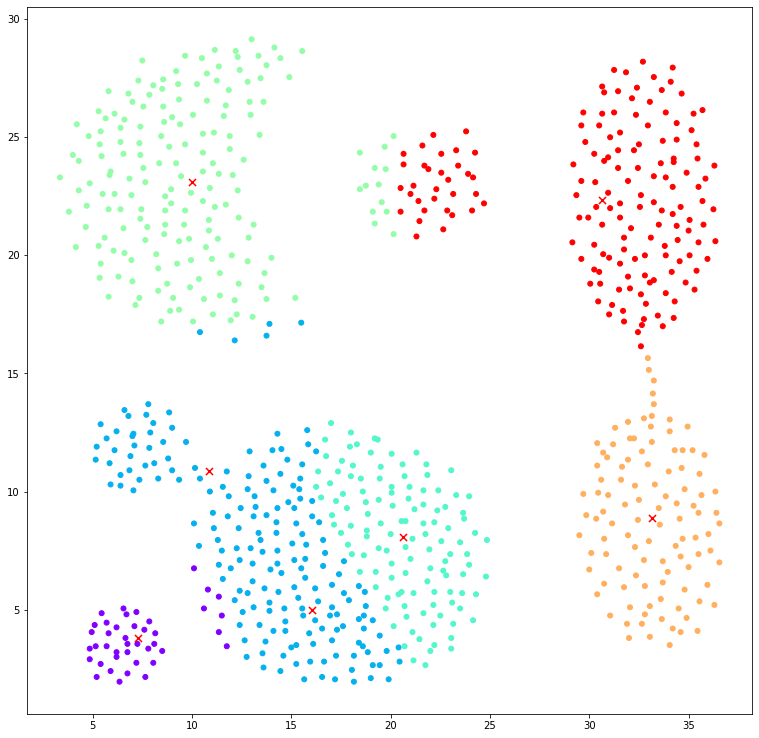

In [10]:
xdata, ydata, centroid = zip(*point_centroid.collect())

x, y = zip(*final_centroids)
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)

ax1.scatter(xdata, ydata, s=25, cmap=plt.get_cmap('rainbow'), c=list(map(kmeans_color_hash, centroid)), marker="o")
ax1.scatter(x, y, s=50, color='r', marker="x")

## sklearn.cluster.DBSCAN exploration
We are going to use a local dbscan algorithm for each partion. In this section we will explore the results of the alogrithm and how to use it.

In [11]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1, min_samples=2).fit(parsed_data.collect())

The alorithm is labeling each data point with a label

In [12]:
labels = clustering.labels_
labels

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

Lets plot the results and see how accuarte this algorthim is for this data set.

In [13]:
def cmap_with_noice(ncolros=7):
    """
    Create a special color map for DBSCAN alorithm.
    It uses a regualr color map but map the smallest value to black.
    We asume that the noice is labled with -1 and all the other labels are non negative
    """
    rainbow = plt.get_cmap('rainbow', ncolros)
    newcolors = rainbow(np.linspace(0, 1, ncolros))
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors, 0, black, 0)  
    return matplotlib.colors.ListedColormap(newcolors)

dbscan_cmap = cmap_with_noice()

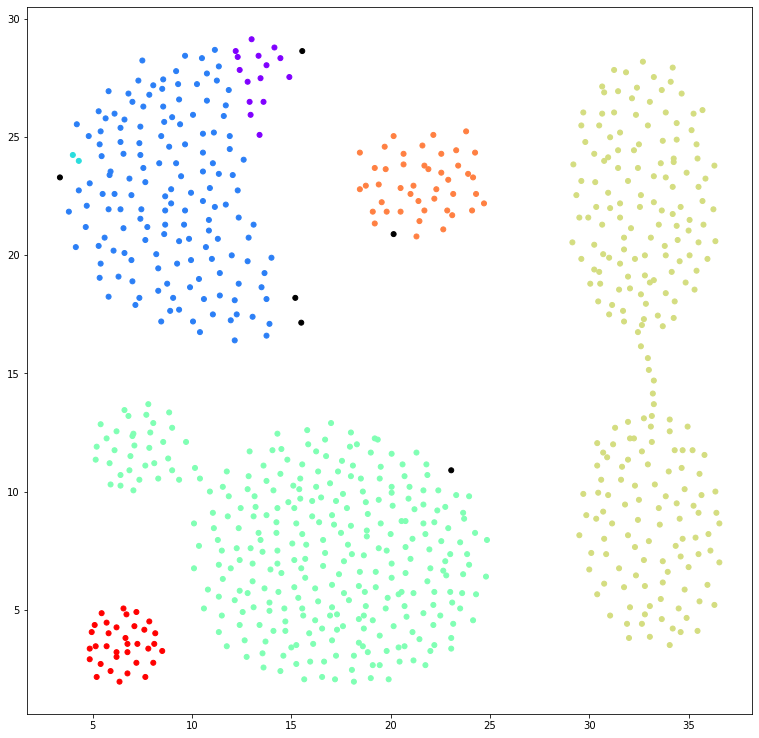

In [14]:
x, y = zip(*parsed_data.collect())

fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=25, c=labels, cmap=dbscan_cmap, marker="o")

In [15]:
class DBSCAN(object):
    def __init__(self, 
                 eps:float=0.5, 
                 min_samples:int=5, 
                 max_partitions:int=None):
        self.eps = eps
        self.min_samples = int(min_samples)
        self.max_partitions = max_partitions

        self.data = None
        self.result = None
        self.bounding_boxes = None
        self.expanded_boxes = None
        self.neighbors = None
        self.cluster_dict = None

    def train(self, data: pyspark.RDD):
        """
        :param data: (key, k-dim vector like)
        
        Train the model using a (key, vector) RDD
        """
        parts = KDPartitioner(data, self.max_partitions)
        self.data = data
        self.bounding_boxes = parts.bounding_boxes
        self.expanded_boxes = {}
        self._create_neighborhoods()
        
        # repartition data set on the partition label
        self.data = self.data.map(lambda ((k, p), v): (p, (k, v))) \
            .partitionBy(len(parts.partitions)) \
            .map(lambda (p, (k, v)): ((k, p), v))
        
        # create parameters for sklearn DBSCAN
        params = {'eps': self.eps, 'min_samples': self.min_samples}
        
        # perform dbscan on each part
        self.data = self.data.mapPartitions(
            lambda iterable: dbscan_partition(iterable, params))
        
        self.data.cache()
        self._remap_cluster_ids()

    def assignments(self):
        """
        :rtype: list
        :return: list of (key, cluster_id)
        Retrieve the results of the DBSCAN
        """
        return self.result.collect()

    def _create_neighborhoods(self):
        """
        Expands bounding boxes by 2 * eps and creates neighborhoods of
        items within those boxes with partition ids in key.
        """
        neighbors = {}
        new_data = self.data.context.emptyRDD()
        for label, box in self.bounding_boxes.iteritems():
            expanded_box = box.expand(2 * self.eps)
            self.expanded_boxes[label] = expanded_box
            neighbors[label] = self.data.filter(
                lambda (k, v): expanded_box.contains(v)) \
                .map(lambda (k, v): ((k, label), v))
            new_data = new_data.union(neighbors[label])
        self.neighbors = neighbors
        self.data = new_data

    def _remap_cluster_ids(self):
        """
        Scans through the data for collisions in cluster ids, creating
        a mapping from partition level clusters to global clusters.
        """
        labeled_points = self.data.groupByKey()
        labeled_points.cache()
        mapper = labeled_points.aggregate(ClusterAggregator(), add, add)
        b_mapper = self.data.context.broadcast(mapper.fwd)
        self.result = labeled_points \
            .map(lambda x: map_cluster_id(x, b_mapper)) \
            .sortByKey()
        self.result.cache()

SyntaxError: invalid syntax (3058569763.py, line 30)

In [ ]:
lambda (a,b): a + b

In [ ]:
v = parsed_data.first()

In [ ]:
parsed_data.aggregate?

In [32]:
class KDPartitioner:
    def __init__(self, data: pyspark.RDD, max_partitions: int):
        self.data = data
        self.data.cache()
        self.max_partitions = max_partitions
        self.k = len(data.first())
        
    def prepare_data(self):
        key_value_partition_data = self.data.map(
            lambda point: (
                (hash(tuple(point)), 0), 
                point
            )
        )
        return key_value_partition_data
        
 
        

In [33]:
kdp = KDPartitioner(parsed_data, 4)

In [34]:
data = kdp.prepare_data()
data.take(5)

[((8920681179070268692, 0), array([15.55, 28.65])),
 ((2311689826667744845, 0), array([14.9 , 27.55])),
 ((2083418302252659608, 0), array([14.45, 28.35])),
 ((-8455583406024911985, 0), array([14.15, 28.8 ])),
 ((4730793792474715724, 0), array([13.75, 28.05]))]